The code are structured as follows:

## Variations within single model size

- within/across pretraining seed difference
- 0/1 loss bias-finetuningvariance-pretrainingvariance-decomposition
- variance conditioned on bias
- squared loss decomposition using probability assigned to the correct label

## Estimating the Fraction of Decaying Instances with Random Baseline

- Our approach, with CDF visualization
- Comparison with the conventional Benjamini-Hochberg Procedure
- Example decaying instances

## Correlation of Instance Difference

- instance difference as measured by pearson-r correlation (numbers represent models sizes, smaller numbers correspond to smaller models)
- measuring with spearman rank

**Some results might be different from that in the paper due to random seeds; however they should be close and lead to the exact qualitative conclusions.**


In [1]:
import pickle as pkl
from decompose_bias_variance import batch_decompose_bias_variance
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from utils import get_regressed_y, calculate_diff_3D, get_binned_result
import os
import matplotlib.image as mpimg
import random
from itertools import chain
from scipy.stats import pearsonr, fisher_exact, spearmanr

In [2]:
task2group = {'qqp': 'dev', 'mnli': 'dev_matched', 'sst-2': 'train'}
model_sizes = ['mini', 'small', 'medium', 'base', 'large']
tasks = ['sst-2'] # use tasks = ['sst-2', 'qqp', 'mnli'] to explore results for other tasks

## Variations within single model size

- within/across pretraining seed difference
- 0/1 loss bias-finetuningvariance-pretrainingvariance-decomposition
- variance conditioned on bias
- squared loss decomposition using probability assigned to the correct label

In [3]:
task2size2correctness = {}

# report accuracy of different model sizes and their differences, for each group
for task in tasks:
    size2correctness, data = pkl.load(open('correctness/{task}.pkl'.format(task=task), 'rb'))
    idxes = []
    for idx, d in enumerate(data):
        if d['guid'].split('-')[0] == task2group[task]:
            idxes.append(idx)
    
    task2size2correctness[task] = {size: size2correctness[size][idxes] for size in model_sizes} 

sst-2


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


\begin{tabular}{llllll}
\toprule
{} &   bias\textasciicircum 2 & pretrain\_variance & finetune\_variance & within\_pretrain\_diff & inter\_pretrain\_diff \\
\midrule
mini   & 5.43E-02 &          3.75E-03 &          1.28E-02 &             2.56E-02 &            3.31E-02 \\
small  & 4.50E-02 &          2.54E-03 &          1.13E-02 &             2.27E-02 &            2.77E-02 \\
medium & 4.27E-02 &          3.33E-03 &          1.04E-02 &             2.08E-02 &            2.75E-02 \\
base   & 4.10E-02 &          2.10E-03 &          9.68E-03 &             1.94E-02 &            2.36E-02 \\
large  & 3.93E-02 &          1.14E-03 &          1.02E-02 &             2.05E-02 &            2.28E-02 \\
\bottomrule
\end{tabular}

To save computation this notebook does not use Gaussian process


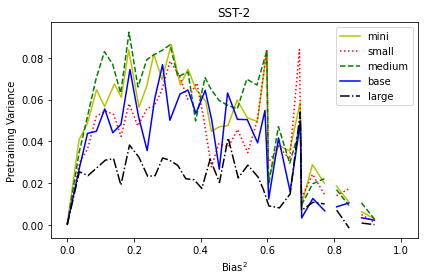

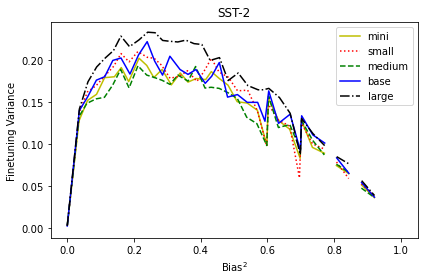

In [4]:
# 0/1 Loss
regress = True

pd.set_option('display.float_format', lambda x: '%.2E' % x)

for task in tasks:
    print('============')
    print(task)
    size2stats = {}
    bias_X = np.arange(0, 1, 0.01)
    
    for size in model_sizes:
        stats = {}
        size2stats[size] = stats
        bias_X = np.arange(0, 1, 0.01)
        correctness = task2size2correctness[task][size][:,:,:,-1]
        
        # bias variance decomposition
        bias_squared, variances = batch_decompose_bias_variance(correctness, 1)
        stats['bias^2'], stats['pretrain_variance'], stats['finetune_variance'] = np.mean(bias_squared), np.mean(variances[:,0]), np.mean(variances[:,1])
        
        # within/across pretraining seeds difference
        stats['within_pretrain_diff'], stats['inter_pretrain_diff'] = calculate_diff_3D(correctness)

        # this pert regresses the variance conditioned on the bias
        if regress:
            # the gaussian process takes a long time to run
            # here is a simpler binned regression
            #stats['regressed_pretrain_variance'] = get_regressed_y(bias_squared, variances[:, 0], bias_X)
            #stats['regressed_finetune_variance'] = get_regressed_y(bias_squared, variances[:, 1], bias_X)
            stats['regressed_pretrain_variance'] = get_binned_result(bias_squared, variances[:, 0])
            stats['regressed_finetune_variance'] = get_binned_result(bias_squared, variances[:, 1])
        
        
    df = pd.DataFrame(size2stats)
    print(df.T.to_latex(columns=['bias^2', 'pretrain_variance', 'finetune_variance', 
                                 'within_pretrain_diff', 'inter_pretrain_diff']))
    
    if regress:
        print('To save computation this notebook does not use Gaussian process')
        for size, c, s in zip(model_sizes, 'yrgbk', ['-', ':', '--', '-', '-.']):
            x, y = size2stats[size]['regressed_pretrain_variance']
            plt.plot(x, y, c=c, label=size, linestyle=s)
        plt.title(task.upper())
        plt.ylabel('Pretraining Variance')
        plt.xlabel(r'Bias$^{2}$')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.title(task.upper())
        for size, c, s in zip(model_sizes, 'yrgbk', ['-', ':', '--', '-', '-.']):
            x, y = size2stats[size]['regressed_finetune_variance']
            plt.plot(x, y, c=c, label=size, linestyle=s)
        plt.ylabel('Finetuning Variance')
        plt.xlabel(r'Bias$^{2}$')
        plt.legend()
        plt.tight_layout()
        plt.show()
            

sst-2
\begin{tabular}{llll}
\toprule
{} &   bias\textasciicircum 2 & pretrain\_variance & finetune\_variance \\
\midrule
mini   & 5.42E-02 &          3.72E-03 &          1.13E-02 \\
small  & 4.48E-02 &          2.38E-03 &          8.38E-03 \\
medium & 4.26E-02 &          3.28E-03 &          8.93E-03 \\
base   & 4.08E-02 &          2.05E-03 &          7.75E-03 \\
large  & 3.92E-02 &          1.11E-03 &          8.68E-03 \\
\bottomrule
\end{tabular}

To save computation this notebook does not use Gaussian process


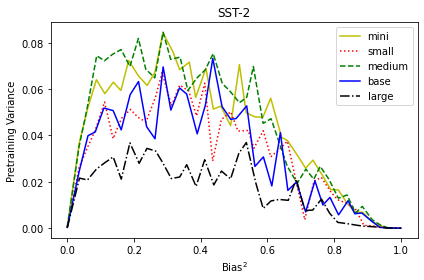

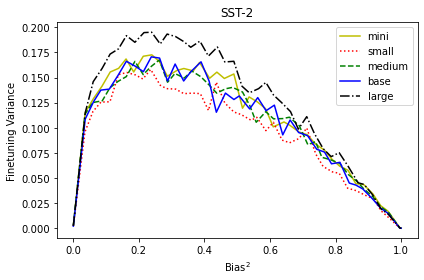

In [5]:
task2size2probs = {}

# report accuracy of different model sizes and their differences, for each group
for task in tasks:
    size2probs, data = pkl.load(open('correctness_p/{task}.pkl'
                                           .format(task=task), 'rb'))
    idxes = []
    for idx, d in enumerate(data):
        if d['guid'].split('-')[0] == task2group[task]:
            idxes.append(idx)
    
    task2size2probs[task] = {size: size2probs[size][idxes] for size in model_sizes}

# squared Loss
for task in tasks:
    print('============')
    print(task)
    size2stats = {}
    bias_X = np.arange(0, 1, 0.01)
    
    for size in model_sizes:
        stats = {}
        size2stats[size] = stats
        bias_X = np.arange(0, 1, 0.01)
        probs = task2size2probs[task][size][:,:,:,-1]
        bias_squared, variances = batch_decompose_bias_variance(probs, 1)
        stats['bias^2'], stats['pretrain_variance'], stats['finetune_variance'] = np.mean(bias_squared), np.mean(variances[:,0]), np.mean(variances[:,1])
        
        if regress:
            # the gaussian process takes a long time to run
            # here is a simpler binned regression
            #stats['regressed_pretrain_variance'] = get_regressed_y(bias_squared, variances[:, 0], bias_X)
            #stats['regressed_finetune_variance'] = get_regressed_y(bias_squared, variances[:, 1], bias_X)
            stats['regressed_pretrain_variance'] = get_binned_result(bias_squared, variances[:, 0])
            stats['regressed_finetune_variance'] = get_binned_result(bias_squared, variances[:, 1])
        
        
    df = pd.DataFrame(size2stats)
    print(df.T.to_latex(columns=['bias^2', 'pretrain_variance', 'finetune_variance']))
    
    if regress:
        print('To save computation this notebook does not use Gaussian process')
        for size, c, s in zip(model_sizes, 'yrgbk', ['-', ':', '--', '-', '-.']):
            x, y = size2stats[size]['regressed_pretrain_variance']
            plt.plot(x, y, c=c, label=size, linestyle=s)
        plt.title(task.upper())
        plt.ylabel('Pretraining Variance')
        plt.xlabel(r'Bias$^{2}$')
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.title(task.upper())
        for size, c, s in zip(model_sizes, 'yrgbk', ['-', ':', '--', '-', '-.']):
            x, y = size2stats[size]['regressed_finetune_variance']
            plt.plot(x, y, c=c, label=size, linestyle=s)
        plt.ylabel('Finetuning Variance')
        plt.xlabel(r'Bias$^{2}$')
        plt.legend()
        plt.tight_layout()
        plt.show()

## Estimating the Fraction of Decaying Instances with Random Baseline

- Our approach, with CDF visualization
- Comparison with the conventional Benjamini-Hochberg Procedure
- Example decaying instances

['sst-2']
sst-2


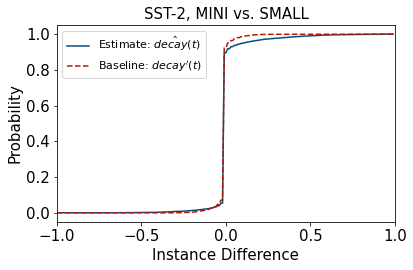

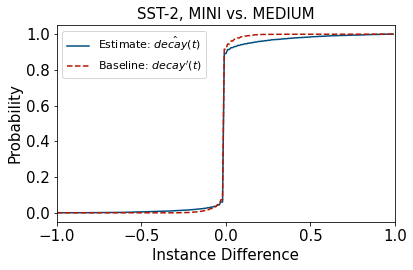

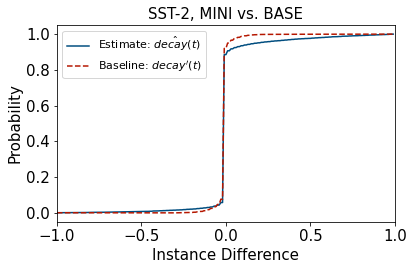

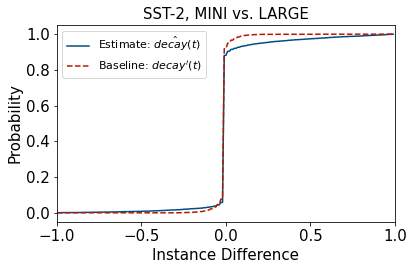

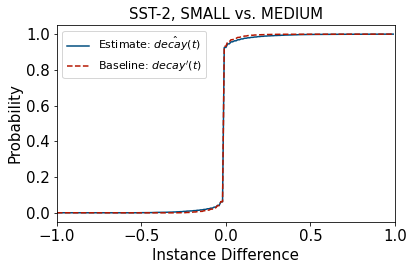

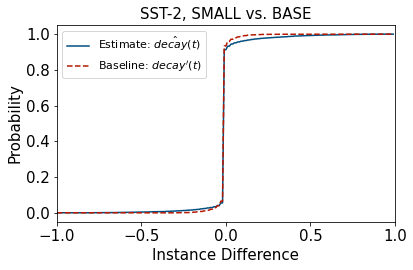

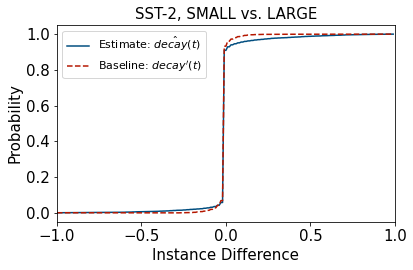

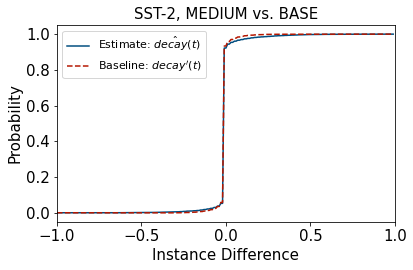

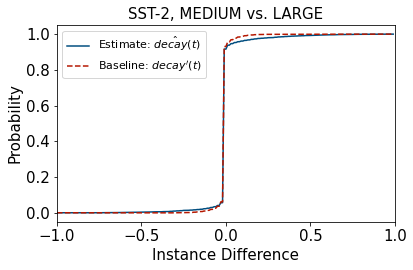

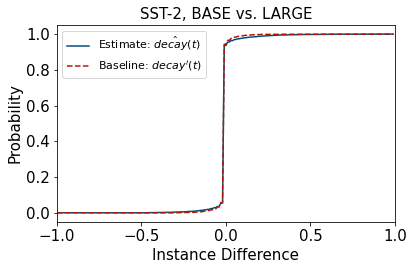

In [6]:
# results of our approach, with CDF visualization
pd.set_option('display.float_format', lambda x: '%.3f' % x)

matplotlib.rc('axes', titlesize=15)
matplotlib.rc('font', size=15)
xs = np.arange(-1, 1, 0.01)

print(tasks)
def get_cum(vs):
    result = np.arange(-1, 1, 0.01)
    for v in vs:
        result[int((v + 1 - 0.001) * 100)] += 1
    result = result / np.sum(result)
    for i in range(199):
        result[i + 1] += result[i]
    return result

task2dfs = {}

bins = np.arange(-0.95, 1.05, 0.1)
for task in tasks:
    print('============')
    print(task)

    comparison_table = {size: {size: None for size in model_sizes} for size in model_sizes}
    size2accs = {size: np.mean(task2size2correctness[task][size][:,:,:,-1], axis=(1, 2))
                for size in model_sizes}
    split1_size2accs = {size: np.mean(task2size2correctness[task][size][:,:5,:,-1], axis=(1, 2))
                        for size in model_sizes}
    split2_size2accs = {size: np.mean(task2size2correctness[task][size][:,5:,:,-1], axis=(1, 2))
                        for size in model_sizes}
    num_data = len(task2size2correctness[task]['base'])
    
    for i in range(len(model_sizes)):
        for j in range(i + 1, len(model_sizes)):
            smaller, larger = model_sizes[i], model_sizes[j]             
            plt.xlim((-1, 1))
            
            es = size2accs[larger] - size2accs[smaller]
            es_cum = get_cum(es)

            mixed_1 = (split1_size2accs[smaller] + split1_size2accs[larger]) / 2
            mixed_2 = (split2_size2accs[smaller] + split2_size2accs[larger]) / 2
            bl = mixed_2 - mixed_1
            bl_cum = get_cum(bl)
            
            diff = es_cum - bl_cum
            comparison_table[smaller][larger] = np.max(diff)
            comparison_table[larger][smaller] = -np.min(diff)
            
            plt.title(task.upper() + ', %s vs. %s' % (smaller.upper(), larger.upper()))
            plt.xlabel(r'Instance Difference' )
            plt.ylabel('Probability')
            plt.plot(xs, es_cum,color='#004D7F', label=r'Estimate: $\hat{decay}(t)$',
                    linestyle='-')
            plt.plot(xs, bl_cum, color='#B51700', label=r"Baseline: $decay'(t)$",
                    linestyle='--')
            plt.legend(loc='upper left', prop={'size': 11})
            plt.tight_layout()
            plt.show()
    df = pd.DataFrame(comparison_table)
    task2dfs[task] = df            

In [7]:
for task, df in task2dfs.items():
    print(task)
    print(df)

sst-2
        mini  small  medium  base  large
mini     nan  0.038   0.044 0.052  0.058
small  0.009    nan   0.014 0.029  0.035
medium 0.015  0.008     nan 0.018  0.026
base   0.018  0.014   0.009   nan  0.014
large  0.020  0.017   0.013 0.007    nan


In [8]:
# comparing our approach aginast the conventional Benjamini-Hochberg procedure on ensembled model predictions

task2size2ensemble_correctness = {}

# report accuracy of different model sizes and their differences, for each group
for task in tasks:
    size2ensemble_correctness, data = pkl.load(open('ensemble_c/{task}.pkl'.format(task=task), 'rb'))
    task2size2ensemble_correctness[task] = size2ensemble_correctness

def fisher_test_f_p(s, l):
    num_data, num_models = s.shape
    s_sum, l_sum = np.sum(s, axis=1), np.sum(l, axis=1)
    ps = []
    for a, b in zip(s_sum, l_sum):
        ps.append(fisher_exact([[a, num_models - a], [b, num_models - b]], alternative='greater')[1])
    ps = np.sort(ps)
    fraction = np.arange(1., len(ps) + 1) / len(ps)
    return fraction, ps

In [9]:
print('This cell compares our method against the Benjamini-Hochberg procedure')
print('We commented it out since it takes a long time to run')
"""
for task in tasks:
    print('task', task)
    size2ensemble_correctness = task2size2ensemble_correctness[task]
    
    for half_size in range(1, 6):
        num_pretrain = 2 * half_size
        print('%d independent pretraining seeds.' % num_pretrain)
        for i, small in enumerate(model_sizes):
            for large in model_sizes[i + 1:]:
                print(small, '->', large)
                s, l = size2ensemble_correctness[small], size2ensemble_correctness[large]
                s_accs, l_accs = np.mean(s[:, :num_pretrain], axis=-1), np.mean(l[:, :num_pretrain], axis=-1)
                mixed_1_accs = (np.mean(s[:,:half_size], axis=-1) + np.mean(l[:,:half_size], axis=-1)) / 2
                mixed_2_accs = (np.mean(s[:,half_size:num_pretrain], axis=-1) + np.mean(l[:,half_size:num_pretrain], axis=-1)) / 2
                es = l_accs - s_accs
                es_cum = get_cum(es)

                bl = mixed_2 - mixed_1
                bl_cum = get_cum(bl)
                diff = es_cum - bl_cum
                our_lower_bound = np.max(diff)

                # Benjamini hochberg procedure
                f2, p2 = fisher_test_f_p(s[:, :num_pretrain], l[:, :num_pretrain])
                discover = []
                for fdr in np.arange(0.01, 1, 0.01):
                    for f, p in zip(f2, p2):
                        if p > f * fdr:
                            discover.append(f * (1 - fdr))
                            break
                BH_lowerbound = np.max(discover)
                print('Ours %.4f' % our_lower_bound)
                print('BH   %.4f' % BH_lowerbound)
    """


This cell compares our method against the Benjamini-Hochberg procedure
We commented it out since it takes a long time to run


"\nfor task in tasks:\n    print('task', task)\n    size2ensemble_correctness = task2size2ensemble_correctness[task]\n    \n    for half_size in range(1, 6):\n        num_pretrain = 2 * half_size\n        print('%d independent pretraining seeds.' % num_pretrain)\n        for i, small in enumerate(model_sizes):\n            for large in model_sizes[i + 1:]:\n                print(small, '->', large)\n                s, l = size2ensemble_correctness[small], size2ensemble_correctness[large]\n                s_accs, l_accs = np.mean(s[:, :num_pretrain], axis=-1), np.mean(l[:, :num_pretrain], axis=-1)\n                mixed_1_accs = (np.mean(s[:,:half_size], axis=-1) + np.mean(l[:,:half_size], axis=-1)) / 2\n                mixed_2_accs = (np.mean(s[:,half_size:num_pretrain], axis=-1) + np.mean(l[:,half_size:num_pretrain], axis=-1)) / 2\n                es = l_accs - s_accs\n                es_cum = get_cum(es)\n\n                bl = mixed_2 - mixed_1\n                bl_cum = get_cum(bl)\

In [10]:
# examples of decaying instances, with annotation
from collections import OrderedDict
def transform_data_dict(data_dicts, task_name):
    results = []
    if task_name == 'sst-2':
        for d in data_dicts:
            new_d = OrderedDict()
            new_d['input'] = d['text_a']
            if d['label'] == '0':
                new_d['label'] = 'Negative'
            else:
                new_d['label'] = 'Positive'
            results.append(new_d)

    if task_name == 'mnli':
        for d in data_dicts:
            new_d = OrderedDict()
            new_d['Premise'] = d['text_a']
            new_d['Hypothesis'] = d['text_b']
            new_d['Label'] = d['label'][0].upper() + d['label'][1:]
            results.append(new_d)
    
    if task_name == 'qqp':
        for d in data_dicts:
            new_d = OrderedDict()
            new_d['Question 1'] = d['text_a']
            new_d['Question 2'] = d['text_b']
            if d['label'] == '0':
                new_d['Label'] = 'Non-paraphrase'
            else:
                new_d['Label'] = 'Paraphrase'
            results.append(new_d)
    return results


if 'sst-2' in tasks:
    sst_2 = pkl.load(open('decaying/sst-2LargeWorseThanMini.pkl', 'rb'))
    dev_matched = sst_2['train']
    data, truth, annotation = dev_matched
    annotation = annotation['rz']
    subselection = [idx for idx in range(len(annotation)) if annotation[idx] is not None and truth[idx] == 'treatment']
    data_dicts, annotation = [data[idx] for idx in subselection], [annotation[idx] for idx in subselection]
    data_dicts = transform_data_dict(data_dicts, 'sst-2')
    for data_dict, c in zip(data_dicts, annotation):
        for key, content in data_dict.items():
            print('\\textbf{' + key + '}', ':', content, '\\\\')
        if c == 'Reasonable':
            c = 'Fine'
        if c == 'Correct':
            c = '{\\color{blue}Correct}'
        if c == 'Wrong':
            c = '{\\color{blue}Wrong}'
        print('\\textbf{Category} :', c, '\\\\')
        print('\\\\')

if 'qqp' in tasks:
    qqp = pkl.load(open('decaying/qqpLargeWorseThanMini.pkl', 'rb'))
    dev_matched = qqp['dev']
    data, truth, annotation = dev_matched
    annotation = annotation['rz']
    subselection = [idx for idx in range(len(annotation)) if annotation[idx] is not None and truth[idx] == 'treatment']
    data_dicts, annotation = [data[idx] for idx in subselection], [annotation[idx] for idx in subselection]
    data_dicts = transform_data_dict(data_dicts, 'qqp')
    for data_dict, c in zip(data_dicts, annotation):
        for key, content in data_dict.items():
            print('\\textbf{' + key + '}', ':', content, '\\\\')
        if c == 'Reasonable':
            c = 'Fine'
        if c == 'Correct':
            c = '{\\color{blue}Correct}'
        if c == 'Wrong':
            c = '{\\color{blue}Wrong}'
        print('\\textbf{Category} :', c, '\\\\')
        print('\\\\')

if 'mnli' in tasks:
    mnli = pkl.load(open('decaying/mnliLargeWorseThanMini.pkl', 'rb'))
    dev_matched = mnli['dev_matched']
    data, truth, annotation = dev_matched
    annotation = annotation['rz']
    subselection = [idx for idx in range(len(annotation)) if annotation[idx] is not None and truth[idx] == 'treatment']
    data_dicts, annotation = [data[idx] for idx in subselection], [annotation[idx] for idx in subselection]
    data_dicts = transform_data_dict(data_dicts, 'mnli')

    for data_dict, c in zip(data_dicts, annotation):
        for key, content in data_dict.items():
            print(key, ':', content, '\\\\')
        print('Category:', c, '\\\\')
        print('\\\\')
    

\textbf{input} : predictability is the only winner  \\
\textbf{label} : Negative \\
\textbf{Category} : {\color{blue}Correct} \\
\\
\textbf{input} : abandon their scripts and go where the moment takes them  \\
\textbf{label} : Negative \\
\textbf{Category} : {\color{blue}Correct} \\
\\
\textbf{input} : chases for an hour and then  \\
\textbf{label} : Positive \\
\textbf{Category} : Unsure \\
\\
\textbf{input} : provide much more insight than the inside column of a torn book jacket  \\
\textbf{label} : Negative \\
\textbf{Category} : Unsure \\
\\
\textbf{input} : a children 's party clown  \\
\textbf{label} : Negative \\
\textbf{Category} : Fine \\
\\
\textbf{input} : perhaps even the slc high command found writer-director mitch davis 's wall of kitsch hard going .  \\
\textbf{label} : Negative \\
\textbf{Category} : {\color{blue}Correct} \\
\\
\textbf{input} : own placid way  \\
\textbf{label} : Negative \\
\textbf{Category} : {\color{blue}Correct} \\
\\
\textbf{input} : get on a board

### Correlation of Instance Difference

- instance difference as measured by pearson-r correlation (numbers represent models sizes, smaller numbers correspond to smaller models)
- measuring with spearman rank

In [11]:
print('Measuring correlation with pearson-r')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
size_jumps = [[0,1,2],[1,2,3],[2,3,4],[0,2,4]]
thresholds = np.arange(0, 1, 0.1), np.arange(0.1, 1.1, 0.1)

dicts = {}
for task in tasks:
    size2accs = {size: np.mean(task2size2correctness[task][size][:,:,:,-1], axis=(1,2)) for size in model_sizes}
    for size_jump in size_jumps:
        d = {}
        small, medium, large = size2accs[model_sizes[size_jump[0]]], size2accs[model_sizes[size_jump[1]]], size2accs[model_sizes[size_jump[2]]]
        previous_jump = medium - small
        later_jump = large - medium
        for low, high in zip(*thresholds):
            selection = np.array([idx for idx in range(len(medium)) if low <= medium[idx] < high])
            r, p = pearsonr(previous_jump[selection], later_jump[selection])
            d[low] = r
        dicts[task + ',' + '->'.join([str(i) for i in size_jump])] = d
df = pd.DataFrame(dicts)
print(df.T.to_latex())
            
        

Measuring correlation with pearson-r
\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0.00 &  0.10 &  0.20 &  0.30 &  0.40 &  0.50 &  0.60 &  0.70 &  0.80 &  0.90 \\
\midrule
sst-2,0->1->2 &  0.09 &  0.26 &  0.43 &  0.22 &  0.28 &  0.24 &  0.27 &  0.35 &  0.20 &  0.12 \\
sst-2,1->2->3 &  0.07 &  0.12 &  0.22 &  0.40 &  0.07 &  0.20 &  0.10 &  0.12 &  0.19 &  0.06 \\
sst-2,2->3->4 &  0.01 &  0.24 &  0.29 &  0.35 &  0.19 &  0.19 &  0.26 &  0.39 &  0.15 &  0.03 \\
sst-2,0->2->4 &  0.01 &  0.17 &  0.11 &  0.41 &  0.04 &  0.29 &  0.16 &  0.21 &  0.15 &  0.07 \\
\bottomrule
\end{tabular}



In [12]:
print('Measuring correlation with spearman rank')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
size_jumps = [[0,1,2],[1,2,3],[2,3,4],[0,2,4]]
thresholds = np.arange(0, 1, 0.1), np.arange(0.1, 1.1, 0.1)

dicts = {}
for task in tasks:
    size2accs = {size: np.mean(task2size2correctness[task][size][:,:,:,-1], axis=(1,2)) for size in model_sizes}
    for size_jump in size_jumps:
        d = {}
        small, medium, large = size2accs[model_sizes[size_jump[0]]], size2accs[model_sizes[size_jump[1]]], size2accs[model_sizes[size_jump[2]]]
        previous_jump = medium - small
        later_jump = large - medium
        for low, high in zip(*thresholds):
            selection = np.array([idx for idx in range(len(medium)) if low <= medium[idx] < high])
            r, p = spearmanr(previous_jump[selection], later_jump[selection])
            d[low] = r
        dicts[task + ',' + '->'.join([str(i) for i in size_jump])] = d
df = pd.DataFrame(dicts)
print(df.T.to_latex())

Measuring correlation with spearman rank
\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  0.00 &  0.10 &  0.20 &  0.30 &  0.40 &  0.50 &  0.60 &  0.70 &  0.80 &  0.90 \\
\midrule
sst-2,0->1->2 &  0.18 &  0.32 &  0.39 &  0.22 &  0.30 &  0.20 &  0.27 &  0.34 &  0.18 &  0.10 \\
sst-2,1->2->3 &  0.05 &  0.16 &  0.19 &  0.42 &  0.05 &  0.19 &  0.13 &  0.08 &  0.15 & -0.00 \\
sst-2,2->3->4 &  0.00 &  0.22 &  0.30 &  0.32 &  0.22 &  0.18 &  0.25 &  0.41 &  0.08 &  0.01 \\
sst-2,0->2->4 & -0.03 &  0.24 &  0.09 &  0.40 &  0.02 &  0.30 &  0.17 &  0.14 &  0.10 &  0.05 \\
\bottomrule
\end{tabular}

